In [1]:
simulation_num <- "HepG2"

set.seed(1)

maxsteps = 100
my.minlam <- 10^(-5)
nfold <- 10
outerCV_folds <- 5
graphComponents <- 6
percent <- 0.8

feature.names <- c("K4me1", "K4me3", "K27me3", "K36me3", "K9me3", "K27ac")

intercept_mode <- TRUE

outPath <- "~/mount2/flassoTool/simulation/sim/"
dir.create(outPath,showWarnings = F)

source('~/mount2/flassoTool/wrapper_functions_RSSmeasureModelSelection_gamma_parallel.R')
source('~/mount2/flassoTool/UtilityFunctions_sequentialCV.R')


In [2]:
fileName <- paste("simulation",simulation_num, sep="")

In [3]:
data.x <- log2(1 + as.matrix(read.table(paste("~/mount/DEEP_ChIP_HM/01/HepG2/01_HepG2_newBPs_plus_NFR_minus_divergent.x", sep=""))))
data.y <- log2(1 + as.numeric(readLines(paste("~/mount/DEEP_ChIP_HM/01/HepG2/01_HepG2_newBPs_plus_divergent_mRNA.y", sep=""))))

In [4]:
print(dim(data.x))
print(length(data.y))

[1] 1242  246
[1] 1242


In [5]:
bestGammasIdx <- 1
ctr <- 1

shuffle <- sample(length(data.y))
data.x <- data.x[shuffle,]
data.y <- data.y[shuffle]

In [6]:
bin.cnt <- ncol(data.x)/graphComponents
edgs <- NULL
for(i in 1:graphComponents)
{
    edgs.partial <- c(bin.cnt*(i-1)+1, rep((bin.cnt*(i-1)+2):(bin.cnt*i - 1),each=2),bin.cnt*i)
    edg_i <- c(edgs.partial[seq(1,(length(edgs.partial)/2-2))],edgs.partial[seq(3+(length(edgs.partial)/2),length(edgs.partial))])
    edgs <- c(edgs,edg_i)
}

In [7]:
partition <- data.partition(data.x,data.y,percent=percent)

In [8]:
train.group.rescaled <- group.rescale(partition$train$x,0,1,bin.cnt)
partition$train$x <- train.group.rescaled$x
partition$test$x <- group.rescale(partition$test$x,0,1,bin.cnt,train.group.rescaled$min,train.group.rescaled$max)$x

In [9]:
outer_CV_partitions <- get.outerCV.partitions(data.x,data.y,n.folds=outerCV_folds)

In [10]:
gammas <- 0
  for(i in seq(-1,1)){
    gammas <- c(gammas,(10^i))
  }
gammas <- sort(unique(c(gammas, gammas/2)))
print(gammas)

[1]  0.00  0.05  0.10  0.50  1.00  5.00 10.00


In [11]:
bestgammas <-vector(mode='numeric',length=1)
bestGammasIdx <- 1

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-10



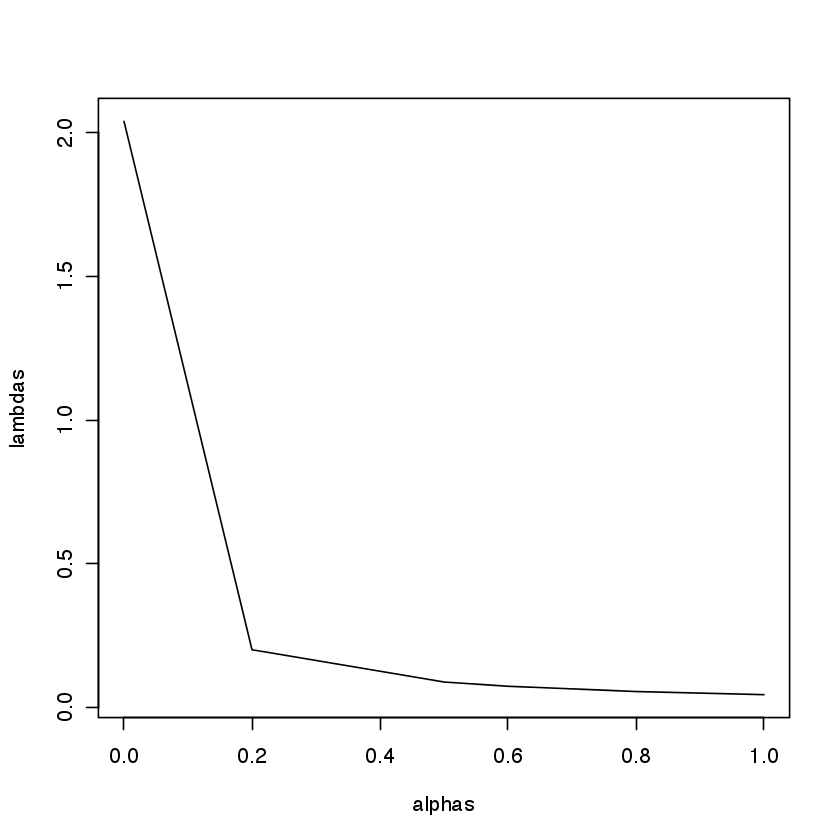

In [12]:
library(glmnet)
alphas <- c(0, .2, .5, .6, .8, 1)
cv.elastic <- list()
el <- list()
pred <- list()

for(i in seq(length(alphas))){
  cv.elastic[[i]] <- cv.glmnet(x= as.matrix(partition$train$x), y= as.numeric(partition$train$y), alpha= alphas[i])
  el[[i]] <- glmnet(x= as.matrix(partition$train$x), y= as.numeric(partition$train$y), alpha= alphas[i], lambda= cv.elastic[[i]]$lambda.min)
  pred[[i]] <- predict(el[[i]], newx= as.matrix(partition$test$x))
}

plot(x= alphas, y= c(cv.elastic[[1]]$lambda.min, cv.elastic[[2]]$lambda.min, cv.elastic[[3]]$lambda.min, cv.elastic[[4]]$lambda.min, cv.elastic[[5]]$lambda.min, cv.elastic[[6]]$lambda.min), xlab= "alphas", ylab= "lambdas", type= "l")


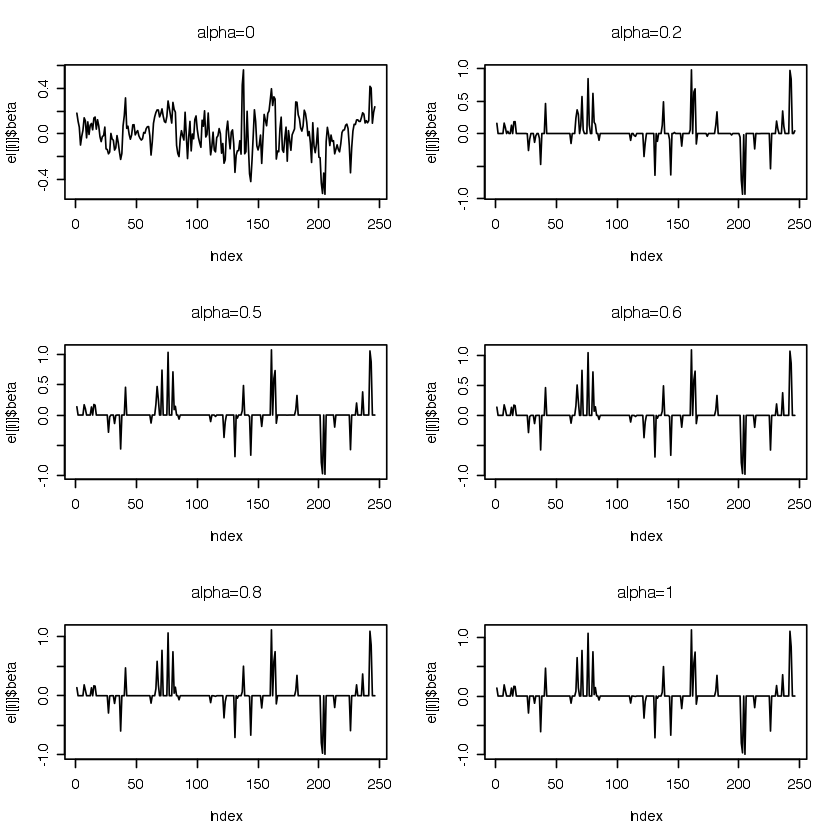

In [13]:
par(mfrow= c(3,2))
for(i in seq(length(alphas)))
  plot(el[[i]]$beta, type= "l", main= paste("alpha=", alphas[i],sep= ""));

[1] "pearson"
[1] "alpha= 0 --> cor= 0.748"   "alpha= 0.2 --> cor= 0.752"
[3] "alpha= 0.5 --> cor= 0.753" "alpha= 0.6 --> cor= 0.753"
[5] "alpha= 0.8 --> cor= 0.753" "alpha= 1 --> cor= 0.752"  
[1] "spearman"
[1] "alpha= 0 --> cor= 0.774"   "alpha= 0.2 --> cor= 0.78" 
[3] "alpha= 0.5 --> cor= 0.781" "alpha= 0.6 --> cor= 0.781"
[5] "alpha= 0.8 --> cor= 0.781" "alpha= 1 --> cor= 0.782"  


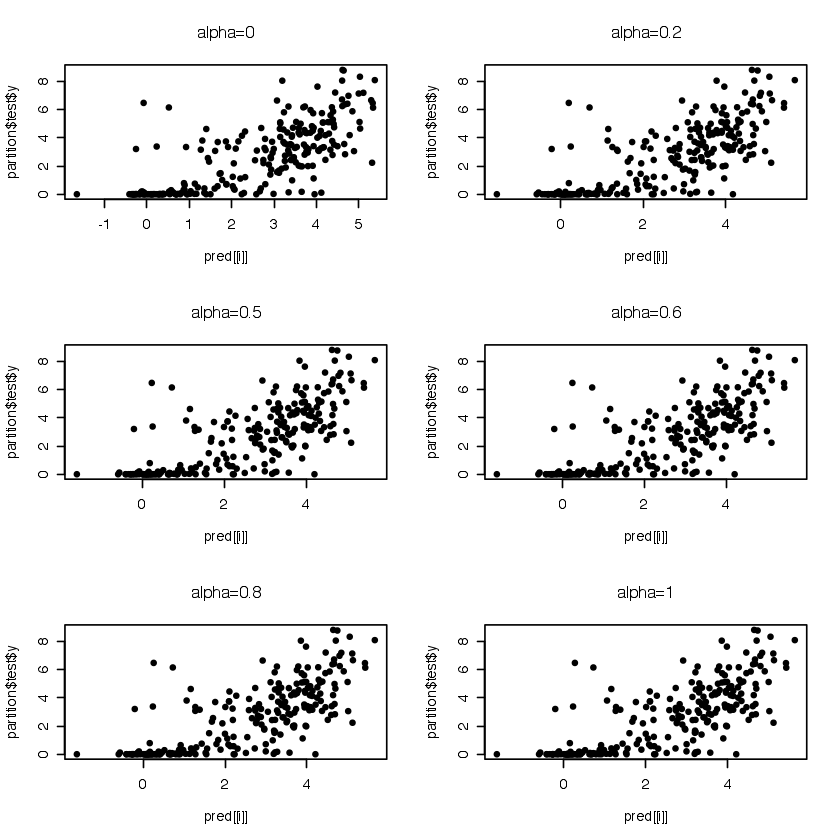

In [14]:
par(mfrow= c(3,2));
for(i in seq(length(alphas)))
  plot(pred[[i]], partition$test$y, pch= 20, main= paste("alpha=", alphas[i],sep= ""));

cors_pearson <- NULL
cors_spearman <- NULL


for(i in seq(length(alphas))){
    cors_pearson <- c(cors_pearson, round(cor(pred[[i]], partition$test$y, method= "pearson"), 3))
    cors_spearman <- c(cors_spearman, round(cor(pred[[i]], partition$test$y, method= "spearman"), 3))
}
print("pearson")
print(paste("alpha=", alphas, "--> cor=", cors_pearson, sep= " "))
print("spearman")
print(paste("alpha=", alphas, "--> cor=", cors_spearman, sep= " "))

In [15]:
#fl.outerCV <- sapply(seq(outerCV_folds),function(i)fusedlasso.main_ForLambdaInterpolation(outer_CV_partitions[[i]]$train$x,outer_CV_partitions[[i]]$train$y,bin.cnt,edgs,gammas,intercept_mode))

In [16]:
fl <- fusedlasso.main_ForLambdaInterpolation(partition$train$x,partition$train$y,bin.cnt,edgs,gammas,intercept_mode)

Loading required package: doSNOW
Loading required package: iterators
Loading required package: snow
Loading required package: scatterplot3d
Loading required package: parallel

Attaching package: ‘parallel’

The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster

Loading required package: genlasso
Loading required package: MASS
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



[1] 70
[1] 30
[1] 7
[1] "0 2.22545394308656"
[1] "0.05 2.39511314860138"
[1] "0.1 2.41699399256511"
[1] "0.5 2.38204763986204"
[1] "1 2.46567190919868"
[1] "5 2.39699855502406"
[1] "10 2.39195331755745"
 [1] "gammas="    "0"          "0"          "0"          "0"         
 [6] "0"          "0"          "0"          "0"          "0"         
[11] "0"          "best.gamma" "0"         
[1] "single gamma set"


In [17]:
best.cv.gamma <- fl$gamma.best

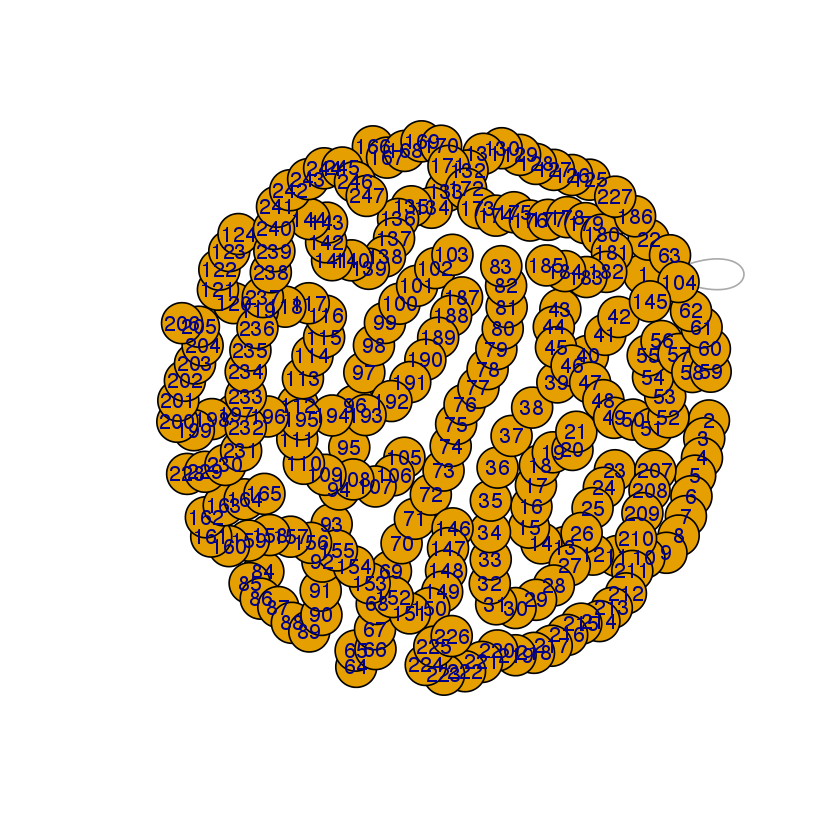

In [18]:
if(intercept_mode){
    edgs <- edgs + 1
    edgs <- c(1,1,edgs)
}
plot(graph(edgs))

if(intercept_mode){
    fl.best <- fusedlasso(X=cbind(1,partition$train$x),y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
}else{
    fl.best <- fusedlasso(X=partition$train$x,y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
}


In [19]:
bestgammas[bestGammasIdx] <- fl$gamma.best
print(fl$gamma.best)

[1] 0


In [20]:
fl.best.min.lambda <- min(fl.best$lambda) 
beta.best <- coef.genlasso(fl.best,max(fl.best.min.lambda,fl$best.lambda))$beta
print('Done running fusedlasso.main')
cv.beta.mat.fl <- fl$cv.fl$cv.beta.mat
print(c('dim(cv.beta.mat.fl)',dim(cv.beta.mat.fl)))
cv.beta.mat.nl <- cv.beta.matrix.nl(partition$train$x,partition$train$y,nfold)

[1] "Done running fusedlasso.main"
[1] "dim(cv.beta.mat.fl)" "10"                  "247"                
[1] "length(nl.beta)" "247"            


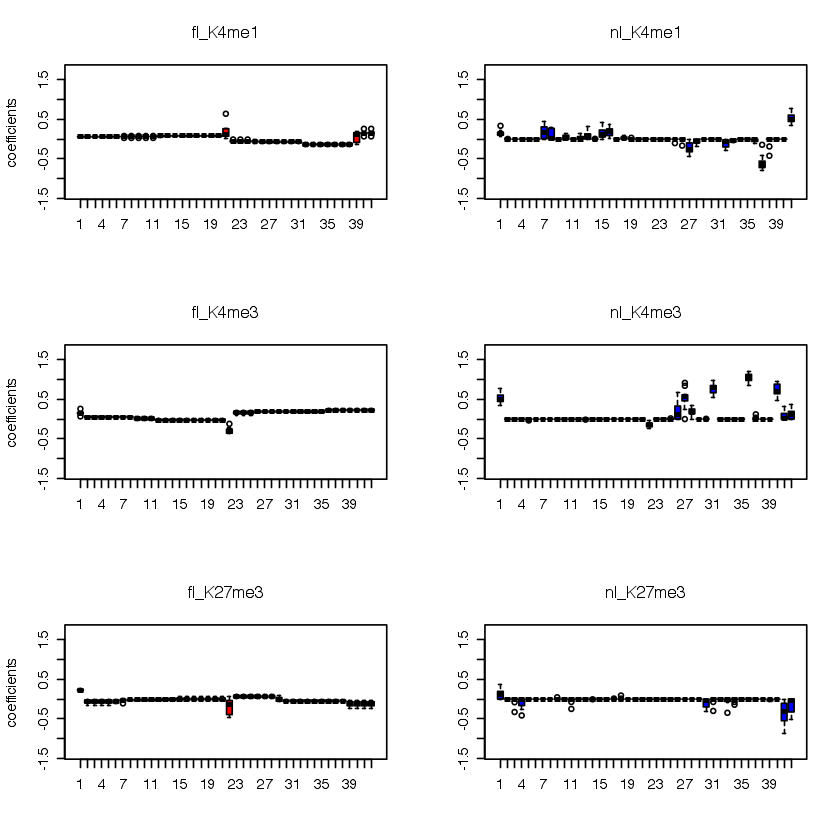

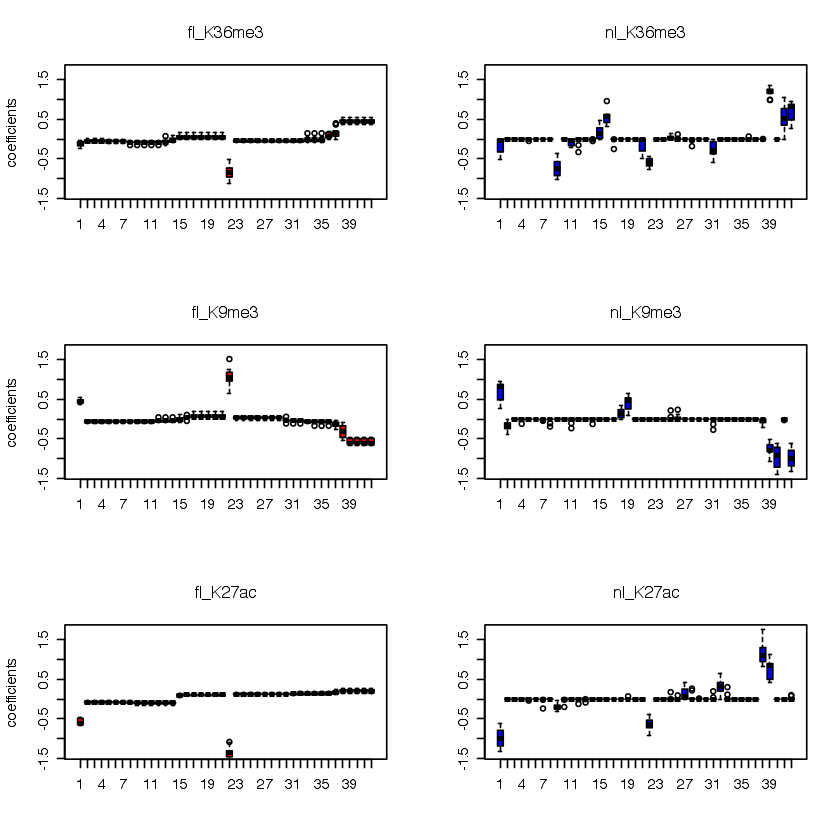

In [21]:
plot.stability(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,bin.cnt,feature.names,intercept_mode)


y_active <- rowSums(d1_active[, seq(19, 30)]) - rowSums(d2_active[, seq(18, 25)]) +
  rnorm(300, mean= 0, sd= .01)
y_inactive <- rowSums(d1_inactive[, seq(19, 30)]) - rowSums(d2_inactive[, seq(18, 25)]) +
rnorm(300, mean= 0, sd= .01)
Y <- c(y_active, y_inactive)

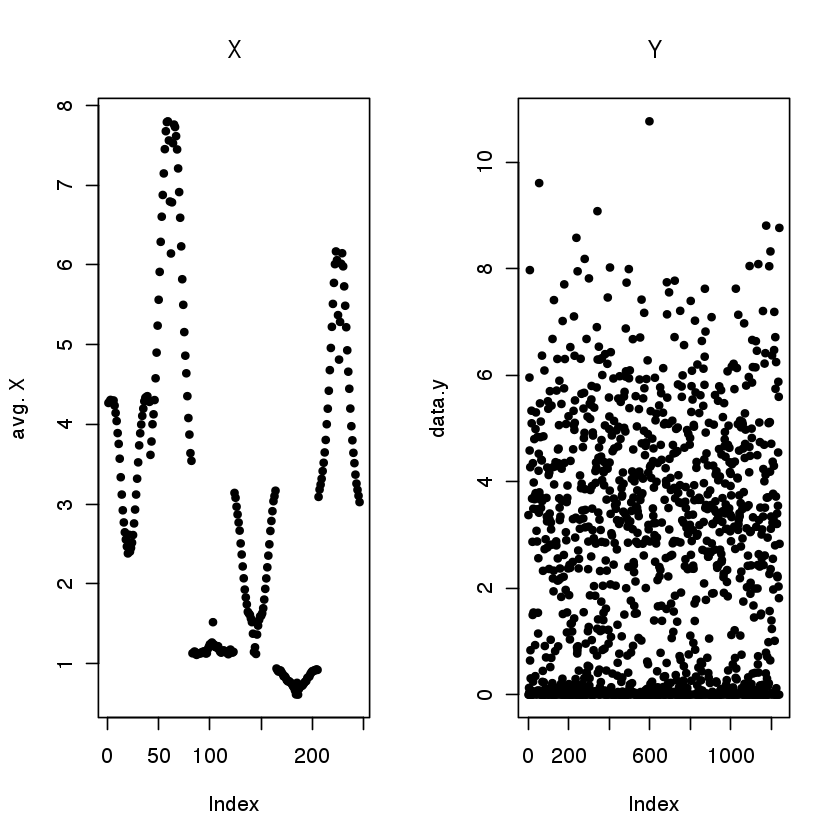

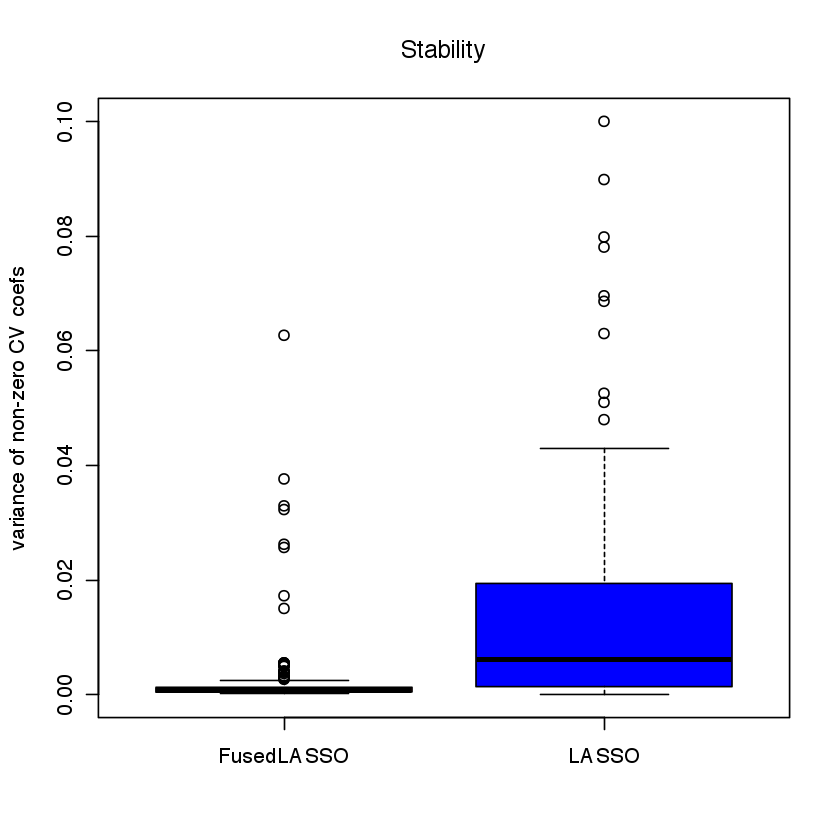

In [22]:
par(mfrow= c(1, 2));
plot(colMeans(data.x), main= "X", ylab= "avg. X", pch= 20)
plot(data.y, main= "Y", pch= 20)
cat("y_active <- rowSums(d1_active[, seq(19, 30)]) - rowSums(d2_active[, seq(18, 25)]) +
  rnorm(300, mean= 0, sd= .01)
y_inactive <- rowSums(d1_inactive[, seq(19, 30)]) - rowSums(d2_inactive[, seq(18, 25)]) +
rnorm(300, mean= 0, sd= .01)
Y <- c(y_active, y_inactive)")

par(mfrow= c(1, 1));
plot.stability.var(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,intercept_mode)

Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



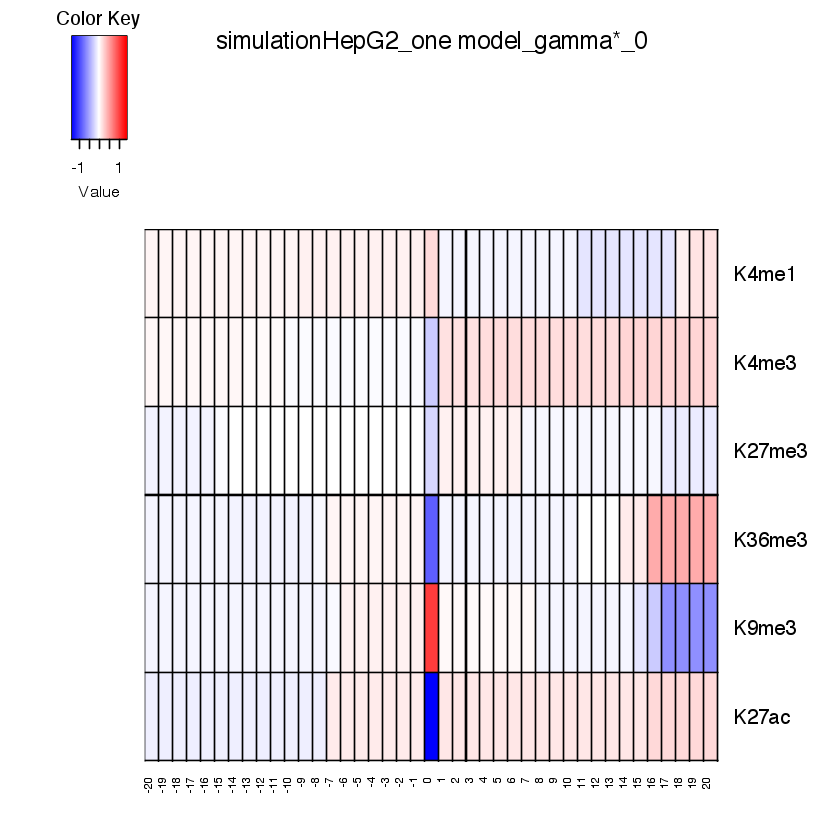

In [23]:
plot.histone.coef(beta.best,bin.cnt,feature.names,main=paste(fileName,'one model','gamma*',bestgammas[bestGammasIdx],sep='_'),intercept_mode)#,cluster_rows = F, cluster_cols = F)

In [24]:
correlations.fl <- matrix(0,ncol=3,nrow=2)#2 rows for spearman and pearson correlation and 3 columns for test, train, and entire dataset
correlations.nl <- matrix(0,ncol=3,nrow=2)

In [25]:
test.y <- partition$test$y
  if(intercept_mode){
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(partition$train$x,partition$test$x)
  }else{
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(train.x,test.x)
  }

$rss
[1] 1.557057

$cor
[1] 0.79 0.77

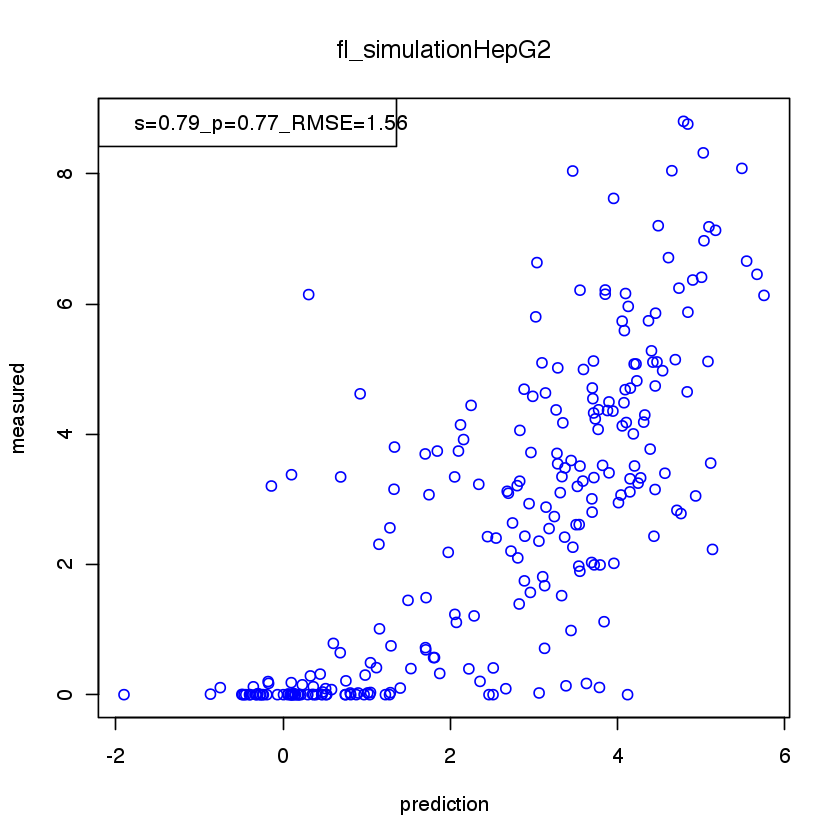

In [26]:
plot.scatter(test.x,test.y,beta.best,0,"measured",main=paste('fl',fileName,sep='_'),is_fl=T,intercept_mode,xlab='prediction')

$rss
[1] 1.548018

$cor
[1] 0.79 0.77

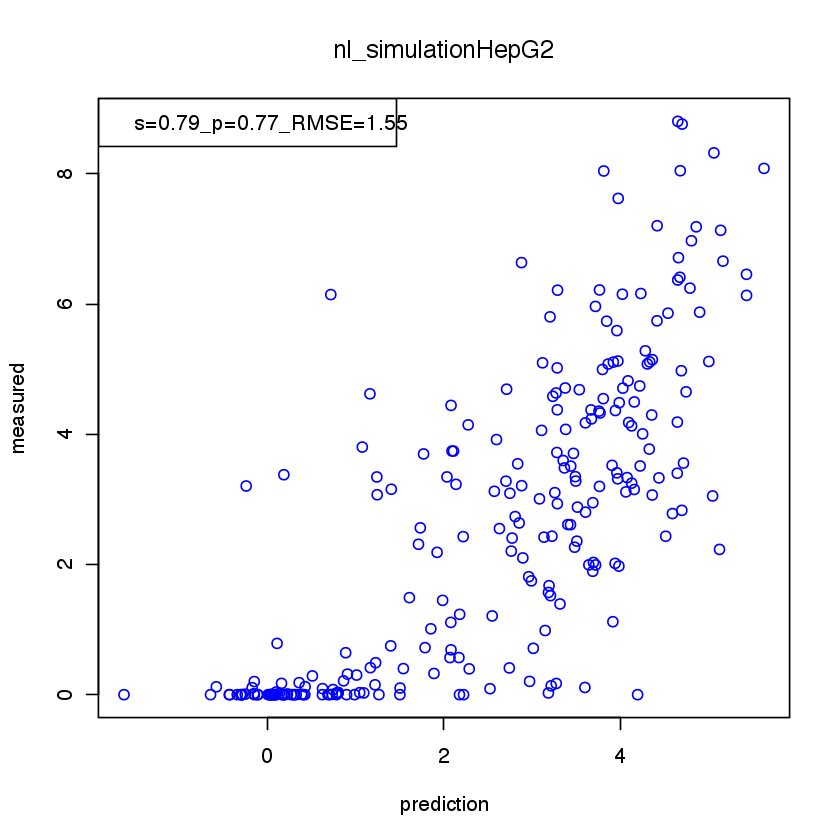

In [27]:
plot.scatter(partition$test$x,partition$test$y,cv.beta.mat.nl$best.nl,0,"measured",main=paste('nl',fileName,sep='_'),is_fl=F,intercept_mode,xlab='prediction')